# Estimating Selection Effects

This notebook accumulates a set of samples in detector-frame masses and distances that are *detected* and corresponding weights (probability density in mass-distance space) that can be used to estimate the selection effects of our hypothetical search.

The distribution we use for injections deserves a bit of comment.  If we could exactly duplicate the physical population, then the relative uncertainty on the selection factor would be $\sim 1/\sqrt{N_\mathrm{det}}$, so, only a factor of a few more sources than the actual number of observed would be sufficient to estimate the selection factor.  (Note: this is not the *optimal* strategy of it is expensive to generate and "inject" signals---in that case, it would be better to track the distribution of *detected* signals instead.)

On the other hand, we don't want to "cheat" and get too close to the actual population.  So, let's choose 
$$
p\left( m_1 \right) \sim \frac{1}{m_1},
$$
with 
$$
p\left( m_2 \mid m_1 \right) \sim \mathrm{const},
$$
so the overall distribution (normalized) is 
$$
p\left( m_1, m_2 \right) = \frac{1}{m_1 \left( m_1 - M_\mathrm{min} \right) \log \left( M_\mathrm{max} / M_\mathrm{min} \right)}.
$$

We want to draw the injections in redshift following a $\gamma = 3$ law in comoving volume
$$
\frac{\mathrm{d} N}{\mathrm{d} V} = \left( 1 + z \right)^{\gamma - 1}
$$
in the Planck15 cosmology.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, RectBivariateSpline
import seaborn as sns
from tqdm import tqdm_notebook

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

First, we load and construct and interpolator to give the optimal SNR for masses and distances:

In [3]:
with h5py.File('optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    osnrs = array(f['SNR'])
    
rbs = RectBivariateSpline(ms, ms, osnrs)

def optimal_snr(m1, m2, d):
    return rbs.ev(m1, m2)/d

Then we construct an interpolator for the distribution of angular factors:

In [4]:
with h5py.File('thetas.h5', 'r') as f:
    ts = array(f['Theta'])
    
ts = np.append([0, 1], ts)
ts = np.sort(ts)

theta_icdf = interp1d(linspace(0, 1, len(ts)), ts)

Now we get the weight function for the events (remember---uniform in log):

In [5]:
MMin = 3
MMax = 200
dLmax = 18 # Gpc---see maximum inferred dL in `InferParameters.ipynb`
zMax = cosmo.z_at_value(Planck15.luminosity_distance, dLmax*u.Gpc)

gamma = 3
z = expm1(linspace(log(1), log(zMax+1), 1000))
dl = Planck15.luminosity_distance(z).to(u.Gpc).value
dVdz = Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value*4*pi
dzddl = 1.0/(dl/(1+z) + (1+z)*Planck15.hubble_distance.to(u.Gpc).value/Planck15.efunc(z))
pz = dVdz*dzddl*(1+z)**(gamma-1)
pdl = pz*dzddl
cdl = cumtrapz(pdl, dl, initial=0)
pdl /= cdl[-1]
cdl /= cdl[-1]

dlicdf = interp1d(cdl, dl)
dlpdf = interp1d(dl, pdl)

def weights(m1det, m2det, dl):
    mwt = 1.0/(m1det*(m1det-MMin)*log(MMax/MMin))
    dlwt = dlpdf(dl)
    
    return mwt*dlwt

def draw_m1m2dl(size=1):
    m1s = exp(log(MMin) + log(MMax/MMin)*rand(size))
    m2s = random.uniform(low=MMin, high=m1s, size=size)
    dls = dlicdf(rand(size))
    
    return (m1s, m2s, dls)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


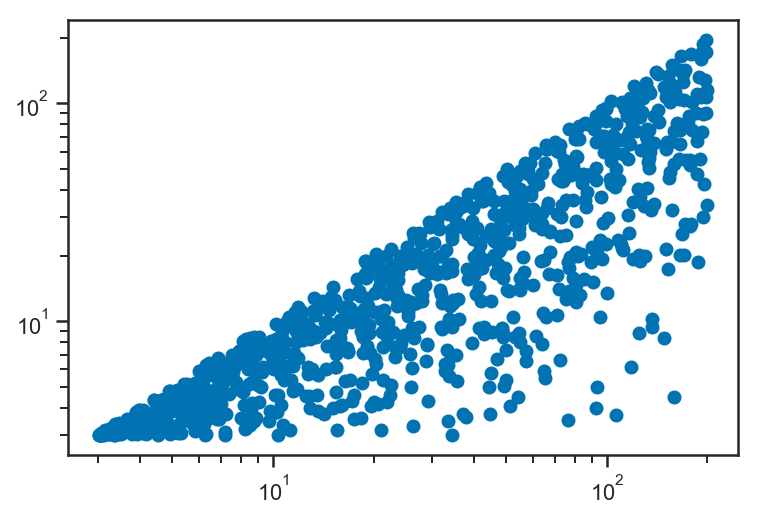

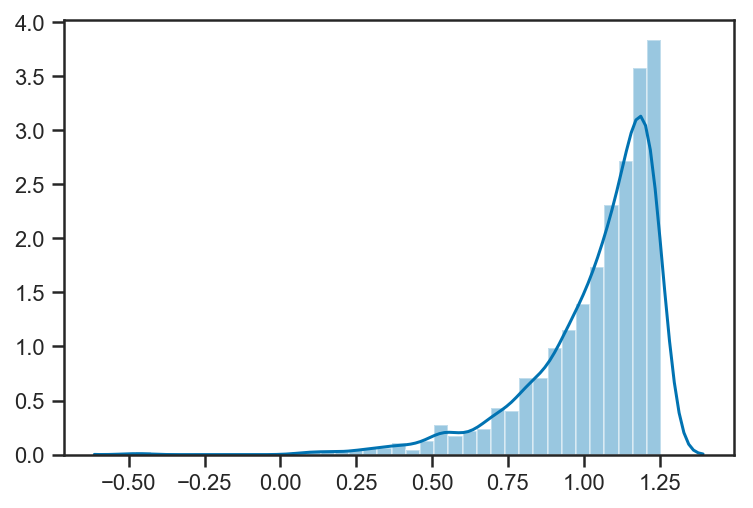

In [6]:
m1s, m2s, dls = draw_m1m2dl(1000)
scatter(m1s, m2s)
xscale('log')
yscale('log')
figure()

sns.distplot(log10(dls))

Here we draw the SNRs of the masses and distances:

In [7]:
def draw_snrs(m1s, m2s, dls):
    n = len(m1s)
    
    t = theta_icdf(rand(n))
    
    return t*optimal_snr(m1s, m2s, dls) + randn(n)

And here we draw the detected events:

In [14]:
m1s_det = []
m2s_det = []
dls_det = []
wts_det = []

N_gen = 0
chunk_size = 1 << 15
N_desired = 1 << 23

with tqdm_notebook(total=N_desired) as bar:
    while len(m1s_det) == 0 or sum([len(x) for x in m1s_det]) < N_desired:
        m1, m2, dl = draw_m1m2dl(size=chunk_size)
        rho = draw_snrs(m1, m2, dl)
        
        N_gen += chunk_size
        
        s = rho > 8
        
        if np.any(s):
            m1s_det.append(m1[s])
            m2s_det.append(m2[s])
            dls_det.append(dl[s])
            wts_det.append(weights(m1[s], m2[s], dl[s]))
            
            bar.update(count_nonzero(s))
            
m1s_det = np.concatenate(m1s_det)
m2s_det = np.concatenate(m2s_det)
dls_det = np.concatenate(dls_det)
wts_det = np.concatenate(wts_det)

And here we save them to HDF5:

In [15]:
with h5py.File('selected.h5', 'w') as f:
    f.attrs['N_gen'] = N_gen
    f.create_dataset('m1det', data=m1s_det, compression='gzip', shuffle=True)
    f.create_dataset('m2det', data=m2s_det, compression='gzip', shuffle=True)
    f.create_dataset('dl', data=dls_det, compression='gzip', shuffle=True)
    f.create_dataset('wt', data=wts_det, compression='gzip', shuffle=True)

A quick test, with a distribution that is close to our reference distribution---should come out to be close to 4000 events expected:

In [16]:
z = linspace(0, 3, 1000)
d = Planck15.luminosity_distance(z).to(u.Gpc).value

z_of_d = interp1d(d, z)

def dNdm1dm2ddl(m1det, m2det, dl):
    z = z_of_d(dl)
    
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)
    
    low_cut = where(m2 < 5, 0, 1)
    high_cut = where(m1 > 40, 0, 1)
    
    dVdz = Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value*4*pi
    dzddl = 1/(dl/(1+z) + (1+z)*Planck15.hubble_distance.to(u.Gpc).value/sqrt((1+z)**3*0.3 + 0.7))
    
    alpha = 0.75
    beta = 0.0
    gamma = 3
    
    MMin = 5
    MMax = 40
    
    m1norm = (1-alpha)/(MMax**(1-alpha) - MMin**(1-alpha))
    m2norm = (beta+1)/(m1**(beta+1) - MMin**(beta+1))
    
    dN = m1norm*m2norm*m1**(-alpha)*m2**beta*(1+z)**(gamma-1)*dVdz*dzddl/(1+z)**2
    
    return low_cut * dN * high_cut

Here we calculate the number of events expected and also the Monte-Carlo uncertainty on that number, and compare to the intrinsic statistical uncertainty, $\sqrt{N}$.

In [17]:
xs = dNdm1dm2ddl(m1s_det, m2s_det, dls_det)/wts_det
s = np.sum(xs)
s2 = np.sum(xs*xs)

v = s2 - s*s/N_gen # var(wt0 + wt1 + ... + wtN + 0 + ... + 0) = N_gen*var([wt0, wt1, ..., wtN, 0, ..., 0])

Nex = 0.5*5*100*s/N_gen
sigma_Nex = sqrt(v)*0.5*5*100/N_gen

Neff = Nex*Nex/(sigma_Nex*sigma_Nex)

Nex, sigma_Nex, sqrt(Nex), (Nex/sigma_Nex)**2

(3636.4560112558697, 3.554922796302048, 60.303034842832496, 1046396.6246158234)